In [ ]:
from collections import Counter
from typing import Self
import functools as ft
import itertools as it

from ising.pauli import SiteBasis

import picos as pc
import numpy as np
import seaborn as sns
from sympy.matrices import Matrix
from scipy.linalg import null_space, eigvalsh
from scipy.special import ellipeinc
from scipy.sparse import csr_array
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from bitarray import bitarray
from bitarray.util import count_and

%load_ext line_profiler

In [2]:
# An efficient implementation of Pauli string operations (arXiV:2405.19287)
# z is bits[::2], x is bits[1::2]

class PauliString:
    CODEC = {'I': bitarray('00'),
             'Z': bitarray('10'),
             'X': bitarray('01'),
             'Y': bitarray('11'),}
    MAT = {'I': np.diag([1, 1]),
           'Z': np.diag([1, -1]),
           'X': np.fliplr(np.diag([1, 1])),
           'Y': np.fliplr(np.diag([-1j, 1j]))}
    def __init__(self, label: str | Self = None, bits: bitarray = None):
        self.bits = None
        self._str = None
        if not ((label is None) ^ (bits is None)):
            raise ValueError("exactly one of label or bits must be provided")
        if bits is None:
            if isinstance(label, str):
                self.bits = bitarray()
                self.bits.encode(self.CODEC, label)
                self._str = label
            elif isinstance(label, PauliString):
                self.bits = label.bits.copy()
            else:
                raise TypeError(f"Unsupported type {type(label)}")
        else:
            if isinstance(bits, bitarray):
                self.bits = bits.copy()
            else:
                raise TypeError(f"Unsupported type {type(bits)}")
    
    def __hash__(self):
        return hash(str(self.bits))

    def __repr__(self):
        if self._str is None:
            self._str = ''.join(self.bits.decode(self.CODEC))
        return self._str
    
    def __eq__(self, other):
        """Equality of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.bits == other.bits

    def __mul__(self, other: Self):
        """Multiply two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other)

    def __or__(self, other: Self):
        """Commutator of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other) if not self.commutes_with(other) else None
    
    def __and__(self, other: Self):
        """Anticommutator of two PauliStrings."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return self.multiply(other) if self.commutes_with(other) else None
    
    def commutes_with(self, other: Self):
        """Check if two Pauli bitarrays commute."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return count_and(self.bits[::2], other.bits[1::2]) % 2 == count_and(self.bits[1::2], other.bits[::2]) % 2
    
    def phase(self, other: Self):
        """Find the phase of the product of two Pauli bitarrays."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return (-1j) ** ((2 * count_and(self.bits[1::2], other.bits[::2])
                          + count_and(self.bits[::2], self.bits[1::2])
                          + count_and(other.bits[::2], other.bits[1::2])
                          - count_and(self.bits[::2] ^ other.bits[::2], self.bits[1::2] ^ other.bits[1::2])) % 4)
    
    def multiply(self, other: Self):
        """Return the Pauli bitarray corresponding to the product of two Pauli bitarrays."""
        if not isinstance(other, PauliString):
            raise TypeError("other is not a PauliString")
        return PauliString(bits=self.bits ^ other.bits)
    
    def to_matrix(self):
        """Return the matrix corresponding to this Pauli string."""
        return ft.reduce(np.kron, (self.MAT[p] for p in self.__repr__()))

class PauliSum:
    # Consider implementing __iter__
    def __init__(self, labels_and_weights: dict[str, complex] | str | PauliString | Self):
        self.terms = None
        if isinstance(labels_and_weights, dict):
            self.terms = self.clean(Counter({PauliString(label): weight for label, weight in labels_and_weights.items()}))
        elif isinstance(labels_and_weights, str):
            self.terms = Counter({PauliString(labels_and_weights): 1.0})
        elif isinstance(labels_and_weights, PauliString):
            self.terms = Counter({PauliString(bits=labels_and_weights.bits): 1.0})
        elif isinstance(labels_and_weights, PauliSum):
            self.terms = labels_and_weights.terms.copy()
        else:
            raise TypeError(f"Unsupported type {type(labels_and_weights)}")
    
    def __hash__(self):
        raise NotImplementedError
    
    def __eq__(self, other: Self):
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        if self.terms.keys() != other.terms.keys():
            return False
        for pstr, weight in self.terms.items():
            if not np.isclose(other.terms[pstr], weight):
                return False
        return True
    
    def __repr__(self):
        if self.is_zero():
            return f'{0j:.2f}'
        return '; '.join(f'{weight:.2f}*{string}' for string, weight in self.terms.items())
    
    def __iadd__(self, other: Self):
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        for pstr, weight in other.terms.items():
            self.terms[pstr] += weight
            if np.isclose(self.terms[pstr], 0):
                del self.terms[pstr]
        return self
    
    def __add__(self, other: Self):
        res = PauliSum(self)
        res += other
        return res

    def __imul__(self, other: complex):
        if not isinstance(other, complex):
            raise TypeError("other is not a complex")
        for pstr in self.terms:
            self.terms[pstr] *= other
        return self

    def __rmul__(self, other: complex):
        if not isinstance(other, complex):
            raise TypeError("other is not a complex")
        res = PauliSum(self)
        res *= other
        return res

    def __mul__(self, other: Self | complex):
        """Multiply two PauliSums."""
        if isinstance(other, PauliSum):
            res = Counter()
            for l1, w1 in self.terms.items():
                for l2, w2 in other.terms.items():
                    res[l1 * l2] += l1.phase(l2) * w1 * w2
            return PauliSum(res)
        elif isinstance(other, complex):
            res = PauliSum(self)
            res *= other
            return res
        raise TypeError(f"Unsupported type {type(other)}")

    def __or__(self, other: Self):
        """Commutator of two PauliSums."""
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        res = Counter()
        for l1, w1 in self.terms.items():
            for l2, w2 in other.terms.items():
                if not l1.commutes_with(l2):
                    res[l1 * l2] += 2 * l1.phase(l2) * w1 * w2
        return PauliSum(res)

    def __and__(self, other: Self):
        """Anticommutator of two PauliSums."""
        if not isinstance(other, PauliSum):
            raise TypeError("other is not a PauliSum")
        res = Counter()
        for l1, w1 in self.terms.items():
            for l2, w2 in other.terms.items():
                if l1.commutes_with(l2):
                    res[l1 * l2] += 2 * l1.phase(l2) * w1 * w2
        return PauliSum(res)
    
    def is_zero(self):
        return not self.terms
    
    @staticmethod
    def _pauli_ord(row: np.ndarray, col: np.ndarray, n: int) -> None:
        if n == 1:
            row[0], col[0] = 0, 0
            row[1], col[1] = 1, 1
            row[2], col[2] = 0, 1
            row[3], col[3] = 1, 0
            return
        PauliSum._pauli_ord(row, col, n - 1)
        pw = 1 << (2 * (n - 1))
        row[1 * pw: 2 * pw] = row[:pw] + (1 << (n - 1))
        col[1 * pw: 2 * pw] = col[:pw] + (1 << (n - 1))
        row[2 * pw: 3 * pw] = row[:pw]
        col[2 * pw: 3 * pw] = col[:pw] + (1 << (n - 1))
        row[3 * pw: 4 * pw] = row[:pw] + (1 << (n - 1))
        col[3 * pw: 4 * pw] = col[:pw]

    @staticmethod
    def _mat_to_vec(matrix: np.ndarray) -> np.ndarray:
        """
        Vectorizes a matrix in Pauli order.
                                                              [vec(A)]
        Given a matrix M = [A B], we vectorize it as vec(M) = [vec(D)].
                           [C D]                              [vec(B)]
                                                              [vec(C)]

        Args:
            matrix: The matrix to vectorize.
        """
        log2n = int(matrix.shape[0]).bit_length() - 1
        row = np.zeros(4 ** log2n, dtype=np.int64)
        col = np.zeros(4 ** log2n, dtype=np.int64)
        PauliSum._pauli_ord(row, col, log2n)
        flat_index = (1 << log2n) * row + col
        return matrix.reshape(-1)[flat_index].astype(np.complex128)

    @staticmethod
    def matrix_decomposition(matrix: np.ndarray) -> np.ndarray:
        """
        Return the weight vector corresponding to the Pauli basis decomposition of a matrix.
        The ordering is IZXY.

        Args:
            matrix: The matrix to be decomposed.
        """
        if matrix.ndim != 2:
            raise ValueError("matrix must be a 2D ndarray")
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError(f"expected square matrix but matrix dimensions \
                            are ({matrix.shape[0]}, {matrix.shape[1]})")
        if matrix.shape[0] == 1:
            raise ValueError("input must be a matrix, not a scalar")
        if int(matrix.shape[0]).bit_count() != 1:
            raise ValueError(f"expected square matrix with power of two \
                            dimensions but matrix dimensions are \
                            ({matrix.shape[0]}, {matrix.shape[1]})")
        b = PauliSum._mat_to_vec(matrix)
        h = 1
        while h < b.shape[0]:
            for i in range(0, b.shape[0], 4 * h):
                x, y = b[i : i + h], b[i + h : i + 2 * h]
                b[i : i + h], b[i + h : i + 2 * h] = (x + y) / 2, (x - y) / 2
                z, w = b[i + 2 * h : i + 3 * h], b[i + 3 * h : i + 4 * h]
                b[i + 2 * h : i + 3 * h], b[i + 3 * h : i + 4 * h] = (z + w) / 2, 1j * (z - w) / 2
            h *= 4
        return b

    @classmethod
    def from_matrix(cls, mat: np.ndarray):
        L = int(mat.shape[0]).bit_length() - 1
        wvec = PauliSum.matrix_decomposition(mat)
        obj = Counter()
        for i, op in enumerate(it.product('IZXY', repeat=L)):
            sop = ''.join(op)
            obj[sop] += wvec[i]
        return PauliSum(obj)

    def to_matrix(self):
        return sum(weight * pstr.to_matrix() for pstr, weight in self.terms.items())

    def clean(self, dirty_counter: Counter):
        """Remove zero terms."""
        return Counter({label: weight for label, weight in dirty_counter.items() if not np.isclose(weight, 0)})

In [3]:
def schwinger_dyson(hamil: PauliSum, word1: str) -> PauliSum:
    return hamil | PauliSum(word1)

def izxy_correspondence(word1: str) -> PauliSum:
    # Even count of X and Y
    mapping = {'I': 'Z', 'Z': 'I', 'X': 'Y', 'Y': 'X'}
    word2 = ''.join(mapping[c] for c in word1)
    return PauliSum({word1: 1.0j, word2: -1j * (-1j) ** ((word1.count('X') + word1.count('Y')) % 4)})

def beta_independent_constraints(basis: SiteBasis, hamil: PauliSum, use_izxy: bool) -> np.ndarray:
    # We handle normalization separately
    n_cols = basis.size() - 1
    A = np.zeros((n_cols, n_cols), dtype=complex)
    for i, word in enumerate(basis._ops[1:]):
        psum = schwinger_dyson(hamil, word)
        if psum.is_zero():
            continue
        for pstr, weight in psum.terms.items():
            A[i, basis.rank(str(pstr)) - 1] += weight
    if use_izxy:
        for i, word in enumerate(basis._ops[1:]):
            if word.count('X') % 2 != 0 or word.count('Y') % 2 != 0:
                continue
            psum = izxy_correspondence(word)
            for pstr, weight in psum.terms.items():
                A[i, basis.rank(str(pstr)) - 1] += weight
    return 1j * A

def construct_hamil(L: int, h: float) -> PauliSum:
    hamil = Counter()
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil[t1] = -1
        hamil[t2] = -h
    if L == 2:
        hamil = Counter({'IZ': -h, 'ZI': -h, 'XX': -1})
    return PauliSum(hamil)

In [4]:
# Now decompose everything
def get_bases(L):
    basis = SiteBasis(L)
    small_basis = SiteBasis(L, use_rot=True, use_reflect=True)
    return basis, small_basis

def decompose(op: PauliSum, A_ns, small_basis):
    res = np.zeros(A_ns.shape[1], dtype=np.complex128)
    for pstr, weight in op.terms.items():
        res += weight * A_ns[small_basis.rank(str(pstr)) - 1, :]
    return res

def get_decomp(A_ns, ops, small_basis):
    decomp_mats = np.zeros((A_ns.shape[1], len(ops), len(ops)), dtype=np.complex128)
    for i, o1 in enumerate(ops):
        for j, o2 in enumerate(ops):
            if i <= j:
                continue
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            p3 = p1 * p2
            decomp_mats[:, i, j] += p1.phase(p2) * A_ns[small_basis.rank(str(p3)) - 1, :]
    return decomp_mats + decomp_mats.conj().transpose((0, 2, 1))

def decompose_sb(op: PauliSum, small_basis):
    res = np.zeros(small_basis.size() - 1, dtype=np.complex128)
    for pstr, weight in op.terms.items():
        res[small_basis.rank(str(pstr)) - 1] += weight
    return res

def get_decomp_sb(ops, small_basis):
    decomp_mats = np.zeros((small_basis.size() - 1, len(ops), len(ops)), dtype=np.complex128)
    for i, o1 in enumerate(ops):
        for j, o2 in enumerate(ops):
            if i <= j:
                continue
            p1 = PauliString(o1)
            p2 = PauliString(o2)
            p3 = p1 * p2
            decomp_mats[small_basis.rank(str(p3)) - 1, i, j] += p1.phase(p2)
    return decomp_mats + decomp_mats.conj().transpose((0, 2, 1))

def get_reorder(matrix):
    n_cc, labels = connected_components(csr_array(matrix), directed=False)
    reord = [y for y, _ in sorted(enumerate(labels), key=lambda x: x[1])]
    return n_cc, reord, labels.tolist()

In [ ]:
def analytical_energy(h):
    return (2 * np.abs(1 - h) / np.pi) * ellipeinc(np.pi / 2, -4 * h / (1 - h) ** 2)

def dm_energy(L, h):
    prob = pc.Problem()
    hamil = construct_hamil(L, h)
    H = hamil.to_matrix()
    # H = csr_array(hamil.to_matrix())
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("min", pc.trace(rho | H))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(rho >> 0)
    # prob.add_constraint(rho * H == H * rho)
    # print(prob)
    return prob.solve(), rho

def dm_energies(L, hs):
    energies = np.zeros_like(hs)
    for i, h in enumerate(hs):
        # print(f'Solving {h:.4f}...')
        energies[i] = -dm_energy(L, h)[0].value/L
    return energies

def nnz(mat):
    return np.count_nonzero(~np.isclose(mat, 0))

def get_energy_problem(hamil, small_basis, P, As, Bs) -> pc.Solution:
    prob = pc.Problem()
    decomp_hamil = np.real(decompose_sb(hamil, small_basis))
    # b = decomp_hamil[:label_counts[0]]
    # c = decomp_hamil[label_counts[0]:]
    # This is the primal problem
    X = pc.HermitianVariable("X", As.shape[1])
    Y = pc.HermitianVariable("Y", Bs.shape[1])
    v = pc.ComplexVariable("v", P.shape[0])
    # w = pc.ComplexVariable("v", Q.shape[0])
    prob.set_objective("max", -(pc.trace(X) +pc.trace(Y)))
    prob.add_constraint(X >> 0)
    prob.add_constraint(Y >> 0)
    # Ptv = P.T * v
    # Qtw = Q.T * w
    # print(P.shape)
    # print(Q.shape)
    # print(b.shape)
    # print(c.shape)
    # print(As.shape)
    # print(Bs.shape)
    # prob.add_list_of_constraints([(X | As[i]) + Ptv[i, :] == b[i] for i in range(As.shape[0])])
    # prob.add_list_of_constraints([(Y | Bs[i]) + Qtw[i, :] == c[i] for i in range(Bs.shape[0])])
    prob.add_list_of_constraints([(X | As[i]) + (Y | Bs[i]) == decomp_hamil[i] for i in range(As.shape[0])])
    return prob

def get_energies(L, hs):
    small_basis = SiteBasis(L, use_reflect=True, use_rot=True)
    hamil = construct_hamil(L, 1)
    A = beta_independent_constraints(small_basis, hamil, use_izxy=False)
    A_ns = null_space(A)
    # Now build the ops from the sparsity pattern
    solve_basis = small_basis
    zero_ops = set(np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
    sparsity = np.ones((solve_basis.size(), solve_basis.size()), dtype=np.int8)
    for i, o1 in enumerate(solve_basis._ops):
        for j, o2 in enumerate(solve_basis._ops):
            if i <= j:
                continue
            if small_basis.rank(str(PauliString(o1) * PauliString(o2))) - 1 in zero_ops:
                sparsity[i, j] = sparsity[j, i] = 0
    _, reord, labels = get_reorder(sparsity)
    label_counts = Counter(labels)
    spops1 = np.array(solve_basis._ops)[reord[:label_counts[0]]]
    spops2 = np.array(solve_basis._ops)[reord[label_counts[0]:]]
    As = get_decomp_sb(spops1, small_basis)
    Bs = get_decomp_sb(spops2, small_basis)
    energies = np.zeros_like(hs)
    prob = get_energy_problem(construct_hamil(L, 1), small_basis, A, As, Bs)
    print(prob)
    for i, h in enumerate(hs):
        print(f'Solving {h:.4f}...')
        hamil = construct_hamil(L, h)
        energies[i] = -get_energy_problem(hamil, small_basis, A, As, Bs).solve().value
    return energies

In [13]:
get_energies(5, np.array([1.0]))

Complex Semidefinite Program
  maximize -(tr(X) + tr(Y))
  over
    68×68 hermitian variables X, Y
  subject to
    X ≽ 0
    Y ≽ 0
    ⟨X, [68×68]⟩ + ⟨Y, [68×68]⟩ = i ∀ i ∈ [0,0,…,0,0]
Solving 1.0000...


array([6.47213595])

Solving 3


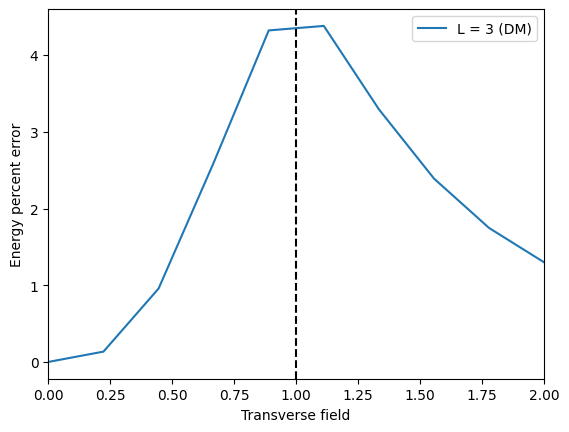

In [40]:
Ls = [3]
hs = np.linspace(1e-3, 2, num=10)
aE = analytical_energy(hs)
for L in Ls:
    print(f'Solving {L}')
    # plt.plot(hs, 100 * np.abs(get_energies(L, hs) - aE) / aE, label=f'L = {L} (basis)')
    plt.plot(hs, 100 * np.abs(dm_energies(L, hs) - aE) / aE, label=f'L = {L} (DM)')
plt.axvline(1, linestyle='--', c='black')
plt.xlim(0,2)
plt.ylabel('Energy percent error')
plt.xlabel('Transverse field')
plt.legend()
plt.show()

In [41]:
def tfimgen(n):
    gens = set()
    xx = "XX" + "I" * (n - 2)
    z = "Z" + "I" * (n - 1)
    for j in range(n):
        gens.add(xx[j:] + xx[:j])
        gens.add(z[j:] + z[:j])
    return list(gens)

In [230]:
L = 6
sol, dm = dm_energy(L, 1)
rho = np.array(dm.value)
rho_ps = PauliSum.from_matrix(rho)

In [99]:
for op in rho_ps.terms.keys():
    if str(op).count('Y') % 2 != 0:
        print(op)

In [43]:
g = [PauliString(x) for x in tfimgen(L)]
gset = set(g)
for a in g:
    for b in g:
        c = a & b
        if c is not None and c not in gset:
            gset.add(c)
            g.append(c)
# print(len(g))
# print(SiteBasis(L, True, True).size())
cg = [str(x) for x in rho_ps.terms.keys()]
g = [str(x) for x in g]
g.sort()
cg.sort()
print(cg)
print(set(g) - set(cg))
print(set(cg) - set(g))

['III', 'IIZ', 'IXX', 'IYY', 'IZI', 'IZZ', 'XIX', 'XXI', 'XXZ', 'XZX', 'YIY', 'YYI', 'YYZ', 'YZY', 'ZII', 'ZIZ', 'ZXX', 'ZYY', 'ZZI', 'ZZZ']
set()
set()


In [44]:
print([str(x) for x in rho_ps.terms.keys()])

['III', 'IIZ', 'IZI', 'IZZ', 'IXX', 'IYY', 'ZII', 'ZIZ', 'ZZI', 'ZZZ', 'ZXX', 'ZYY', 'XIX', 'XZX', 'XXI', 'XXZ', 'YIY', 'YZY', 'YYI', 'YYZ']


In [216]:
com = {}
small_basis = SiteBasis(L, True, True)
for pstr, weight in rho_ps.terms.items():
    rw = np.round(weight, 5)
    pnorm = small_basis.normalize(str(pstr))
    if rw in com:
        com[rw].add(pnorm)
    else:
        com[rw] = {pnorm}
print(*com.items(),sep='\n')

(np.complex128(0.125+0j), {'ZZZ', 'III'})
(np.complex128(0.08333+0j), {'IIZ', 'IZZ', 'IXX'})
(np.complex128(-0.04167+0j), {'IYY'})
(np.complex128(0.04167+0j), {'XXZ'})
(np.complex128(-0.08333+0j), {'YYZ'})


In [231]:
small_basis = SiteBasis(L, use_reflect=True, use_rot=True)
hamil = construct_hamil(L, 1)
A = beta_independent_constraints(small_basis, hamil, use_izxy=False)
A_ns = null_space(A)
zero_ops = set(small_basis.unrank(op + 1) for op in np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
nnz_ops = set(small_basis._ops) - zero_ops
miss_ops = nnz_ops - set([small_basis.normalize(str(op)) for op in rho_ps.terms.keys()])
miss_ops_izxy = set()
for op in miss_ops:
    mapping = {'I': 'Z', 'Z': 'I', 'X': 'Y', 'Y': 'X'}
    izxy_dual = lambda word1: ''.join(mapping[c] for c in word1)
    if small_basis.normalize(op) in miss_ops_izxy or small_basis.normalize(izxy_dual(op)) in miss_ops_izxy:
        continue
    miss_ops_izxy.add(op)
print(miss_ops_izxy)
print(len(nnz_ops))
print(A_ns.shape)

{'XYZXYZ', 'XXXYXY', 'IXYXIY', 'XYXZYZ', 'XZYYYZ', 'IIXYXY', 'IXIZYZ', 'IIXIYZ', 'IXYXYZ', 'IXIXYX', 'XYXYXY', 'IXYXZY', 'IXYZIZ', 'IXYZXY', 'IYXYYZ', 'IIYXZZ', 'IYXYXZ'}
147
(429, 45)


In [187]:
small_basis = SiteBasis(L, use_reflect=True, use_rot=True)
hamil = construct_hamil(L, 1)
A = beta_independent_constraints(small_basis, hamil, use_izxy=True)
A_ns = null_space(A)
zero_ops = set(small_basis.unrank(op + 1) for op in np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
nnz_ops = set(small_basis._ops) - zero_ops
print(len(nnz_ops))
print(A_ns.shape)

706
(1299, 39)


In [48]:
indicator = ~np.isclose(rho, 0)
n_cc, reord, labels = get_reorder(indicator)
print(n_cc)
reord_rho = rho[:, reord][reord, :]
reord_rho_ps=PauliSum.from_matrix(reord_rho)

5


In [49]:
small_basis = SiteBasis(L, True, True)
smod = set([small_basis.normalize(str(op)) for op in rho_ps.terms.keys()])
print(len(smod))
print(len(rho_ps.terms))
print(smod)

8
20
{'ZZZ', 'IIZ', 'IXX', 'YYZ', 'IYY', 'XXZ', 'IZZ', 'III'}


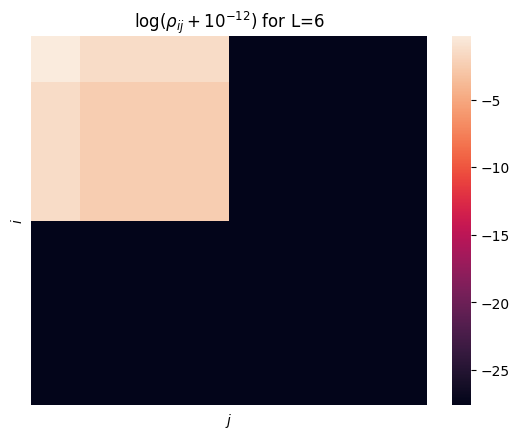

In [50]:
sns.heatmap(np.log(reord_rho + 1e-12), xticklabels=False, yticklabels=False)
plt.title(r'$\log(ρ_{ij} + 10^{-12})$ for L=6')
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')
plt.show()

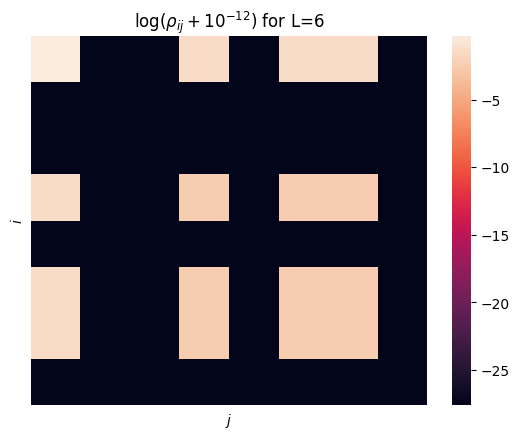

In [51]:
sns.heatmap(np.log(rho + 1e-12), xticklabels=False, yticklabels=False)
plt.title(r'$\log(ρ_{ij} + 10^{-12})$ for L=6')
plt.xlabel(r'$j$')
plt.ylabel(r'$i$')
plt.show()

In [292]:
def dm_tvals(L, h, Es):
    tvals = np.zeros_like(Es)
    hamil = construct_hamil(L, h)
    prob = pc.Problem()
    H = hamil.to_matrix()
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    x = pc.RealVariable("x", H.shape[0])
    prob.set_objective("max", pc.lambda_min(rho))
    prob.add_constraint(pc.trace(rho) == 1)
    Y = pc.block([[rho, x],
                  [x.T, 1.0]])
    prob.add_constraint(Y >> 0)
    for i, E in enumerate(Es):
        print(f'Solving {E:.4f}...')
        Econs = (pc.trace(rho * H) == E)
        prob.add_constraint(Econs)
        if i == 3:
            print(prob)
        tvals[i] = prob.solve().value
        prob.remove_constraint(Econs)
    return tvals

def dm_tval(L, h, E):
    hamil = construct_hamil(L, h)
    H = hamil.to_matrix()
    prob = pc.Problem()
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("max", pc.lambda_min(rho))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(pc.trace(rho * H) == E)
    sobj = prob.solve()
    return sobj.value, rho

In [287]:
L, h = 3, 0.5
np.round(eigvalsh(construct_hamil(L, h).to_matrix()), 4)

array([-3.2321, -3.1458,  0.2321,  0.5   ,  0.5   ,  1.5   ,  1.5   ,
        2.1458])

In [293]:
Es = np.linspace(-3.2, 1, num=100)
ts = dm_tvals(L, h, Es)

Solving -3.2000...
Solving -3.1576...
Solving -3.1152...
Solving -3.0727...
Optimization Problem
  maximize λ_min(ρ)
  over
    8×1 real variable x
    8×8 symmetric variable ρ
  subject to
    tr(ρ) = 1
    [ρ, x; xᵀ, 1] ≽ 0
    tr(ρ·[8×8]) = -3.07273
Solving -3.0303...
Solving -2.9879...
Solving -2.9455...
Solving -2.9030...
Solving -2.8606...
Solving -2.8182...
Solving -2.7758...
Solving -2.7333...
Solving -2.6909...
Solving -2.6485...
Solving -2.6061...
Solving -2.5636...
Solving -2.5212...
Solving -2.4788...
Solving -2.4364...
Solving -2.3939...
Solving -2.3515...
Solving -2.3091...
Solving -2.2667...
Solving -2.2242...
Solving -2.1818...
Solving -2.1394...
Solving -2.0970...
Solving -2.0545...
Solving -2.0121...
Solving -1.9697...
Solving -1.9273...
Solving -1.8848...
Solving -1.8424...
Solving -1.8000...
Solving -1.7576...
Solving -1.7152...
Solving -1.6727...
Solving -1.6303...
Solving -1.5879...
Solving -1.5455...
Solving -1.5030...
Solving -1.4606...
Solving -1.4182...
Solvin

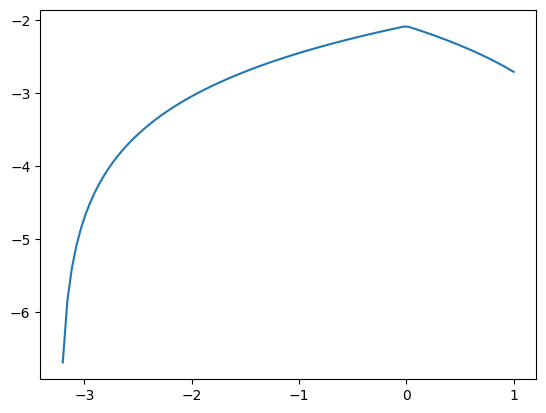

In [294]:
plt.plot(Es, np.log(np.abs(ts)))

In [ ]:
L, h, E = 8, 0.5, 0
t, dm = dm_tval(L, h, E)
print(t)

In [268]:
rho = np.array(dm.value)
rho_ps = PauliSum.from_matrix(rho)
print(rho_ps)

0.06+0.00j*IIII


In [270]:
dm_energy(L, h)[0].value

-6.38469456360371

In [202]:
def xyz_model(L: int, h: float) -> PauliSum:
    hamil = Counter()
    for i in range(L):
        t1x, t1y, t1z = None, None, None
        if i<L-1:
            t1x = 'I'*i + 'XX' + 'I'*(L-i-2)
            t1y = 'I'*i + 'YY' + 'I'*(L-i-2)
            t1z = 'I'*i + 'ZZ' + 'I'*(L-i-2)
        else:
            t1x = 'X' + 'I'*(L-2) + 'X'
            t1y = 'Y' + 'I'*(L-2) + 'Y'
            t1z = 'Z' + 'I'*(L-2) + 'Z'
        t2x = 'I'*i+'X'+'I'*(L-i-1)
        t2y = 'I'*i+'Y'+'I'*(L-i-1)
        t2z = 'I'*i+'Z'+'I'*(L-i-1)
        if t1x is not None:
            hamil[t1x] = -1
            hamil[t1y] = -1
            hamil[t1z] = -1
        hamil[t2x] = -h
        hamil[t2y] = -h
        hamil[t2z] = -h
    if L == 2:
        hamil = Counter({'XX': -1, 'YY': -1, 'ZZ': -1, 'XI': -h, 'IX': -h, 'YI': -h, 'IY': -h, 'ZI': -h, 'IZ': -h})
    return PauliSum(hamil)

def spin_chain_rho(hamil: PauliSum):
    H = hamil.to_matrix()
    prob = pc.Problem()
    rho = pc.SymmetricVariable("ρ", H.shape[0])
    prob.set_objective("min", pc.trace(rho * H))
    prob.add_constraint(pc.trace(rho) == 1)
    prob.add_constraint(rho >> 0)
    prob.solve()
    return np.array(rho.value)

In [210]:
L, h = 4, 1
rho = spin_chain_rho(xyz_model(L, h))
rho_ps = PauliSum.from_matrix(rho)

In [214]:
com = {}
small_basis = SiteBasis(L, use_rot=True, use_reflect=True)
for pstr, weight in rho_ps.terms.items():
    rw = np.round(weight, 5)
    pnorm = small_basis.normalize(str(pstr))
    if rw in com:
        com[rw].add(pnorm)
    else:
        com[rw] = {pnorm}
print(*com.items(),sep='\n')

(np.complex128(0.0625+0j), {'IIII'})
(np.complex128(0.04419+0j), {'IIIZ', 'IIIX'})
(np.complex128(0.03125+0j), {'IIZZ', 'IXIZ', 'IXIX', 'IIXZ', 'IZIZ', 'IIXX'})
(np.complex128(0.0221+0j), {'IXXX', 'IXXZ', 'IZZZ', 'IXZX', 'IZXZ', 'IXZZ'})
(np.complex128(0.01563+0j), {'XXXX', 'ZZZZ'})
(np.complex128(0.01562+0j), {'XZZZ', 'XZXZ', 'XXZZ', 'XXXZ'})


In [410]:
L = 5
hamil = construct_hamil(L, 1)
basis = SiteBasis(L)
small_basis = SiteBasis(L, use_reflect=True, use_rot=True)
A = np.zeros((basis.size(), basis.size()), dtype=np.complex128)
for i, op in enumerate(basis._ops):
    p = PauliString(op)
    for pstr, weight in hamil.terms.items():
        u = p | pstr
        if u is not None:
            A[i, basis.rank(str(u))] += weight * p.phase(pstr)
A_ns = np.real(null_space(1j * A))

In [411]:
zero_ops_inds = set(np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
zero_ops = set(small_basis.normalize(basis.unrank(i)) for i in zero_ops_inds)
nnz_opsf = small_basis._opset - zero_ops
# zero_ops = set(basis.unrank(i) for i in zero_ops_inds)
# nnz_ops = basis._opset - zero_ops
# print(len(zero_ops_inds))
# print(zero_ops)
print(len(nnz_opsf))
print(nnz_opsf)

108
{'IXYZZ', 'IXYZX', 'IXZZY', 'IYXYZ', 'IXYXZ', 'IIIIX', 'IIIYY', 'YZYZZ', 'IYXXY', 'IXYIZ', 'IIXYZ', 'IXXIY', 'IZYZZ', 'YYYZZ', 'XYYYY', 'IYZXZ', 'XZXZZ', 'IXXXX', 'IXIXY', 'IXIXZ', 'IYXXZ', 'IIXIX', 'IYYZZ', 'XXXZZ', 'IXXXZ', 'IYYIZ', 'XYXYZ', 'IZIZZ', 'IXXXY', 'XXYZY', 'XXXYZ', 'IIZZZ', 'IXZXZ', 'IXIYZ', 'IZXZZ', 'IYXZZ', 'XXYYZ', 'XXYZZ', 'IIXIY', 'ZZZZZ', 'IYXYY', 'IIIZZ', 'IXXZY', 'XYZZZ', 'XZYZZ', 'XZYYZ', 'IYIYZ', 'IIIII', 'XYYYZ', 'IIZYZ', 'IXXZZ', 'IXYXY', 'IIXIZ', 'IXYYY', 'IXZIY', 'IZXYZ', 'IXZYZ', 'IIYXZ', 'XYZYZ', 'IIYZY', 'IXXYX', 'YYZZZ', 'XXYXZ', 'XYXYY', 'IXXIZ', 'IIYIY', 'XXXXZ', 'IYZZZ', 'IXZYY', 'YZZZZ', 'IYYYY', 'YYYYZ', 'XXYXY', 'XXZXZ', 'IXZZX', 'IIIIZ', 'IZYYZ', 'IIXZY', 'IIZIZ', 'XYZXZ', 'IIIXZ', 'IXYZY', 'IIYIZ', 'IIYZZ', 'IYZZY', 'IXYYX', 'XYYXZ', 'IIYYY', 'XXXXY', 'IYIYY', 'IXYIY', 'IIXZZ', 'IIXXX', 'IIXXZ', 'XXZZZ', 'IIXYY', 'IZZZZ', 'IYYXZ', 'IYZYZ', 'IYYYZ', 'IXXYY', 'IIIXX', 'IIXZX', 'XYYZY', 'IIYYZ', 'IZXXZ', 'IXIZZ', 'IIIXY'}


In [412]:
A = beta_independent_constraints(small_basis, hamil, False)
A_ns = null_space(A)
zero_ops_inds = set(np.where(np.all(np.isclose(A_ns, 0), axis=1))[0])
zero_ops = set(small_basis.unrank(i + 1) for i in zero_ops_inds)
nnz_ops = small_basis._opset - zero_ops
# print(len(zero_ops_inds))
# print(zero_ops)
print(len(nnz_ops))
print(nnz_ops)

44
{'IXZZX', 'IIIIZ', 'IZYYZ', 'IXIXZ', 'IIZIZ', 'IIYZY', 'IIXIX', 'IYYZZ', 'YYZZZ', 'IYZZY', 'IXYYX', 'XYYXZ', 'IYYIZ', 'IIIYY', 'YZYZZ', 'IXXIZ', 'XYXYZ', 'IZIZZ', 'IYXXY', 'XXYZY', 'XXYYZ', 'IIZZZ', 'IXZXZ', 'IIXXZ', 'IIYIY', 'XXXXZ', 'XXZZZ', 'ZZZZZ', 'IZZZZ', 'IYYYY', 'YYYYZ', 'IYZYZ', 'IIIZZ', 'IXXYY', 'IIIXX', 'IYIYZ', 'XZXZZ', 'IIIII', 'IIXZX', 'IXXXX', 'IXXZZ', 'IXYXY', 'IIYYZ', 'IZXXZ'}
